In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

In [2]:
import os
os.getcwd()

'C:\\Users\\Brad\\Desktop\\Keras - GPU'

## Bottom Line Up Front

Since we trained a model on higher-signal edge cases, we get a model that has a difficult time making consistent correct classifications close to the 0.5 probability/decision point.

In a selection of reviews displayed to a customer, that can be mitigated by either:

1. Sort reviews by binary class predicted probability and show only the top few (highest probability of being "helpful"). For books with a sufficient number of reviews, a customer will be looking at reviews far from the predicted probability threshold of 0.5 (higher support for being "helpful").<br><br>

2. Use a post-classification threshold to ignore "middle" reviews. You will lose some correctly classified reviews with lower predicted probabilities, but with a conservative threshold you will ignore quite a few more incorrectly classified examples.

So, "middle" reviews are relatively easy to deal with. However, "confidently" misclassified examples are another problem.

Among misclassified examples, sometimes when the model faces a short helpful review it predicts unhelpful.

Also, sometimes When the model faces a longer unhelpful review, it predicts helpful.

It should then be no surprise, when review lengths of the training set are examined (final cell in this notebook), that **helpful reviews are on average longer and unhelpful reviews are shorter.**

This might mean that stratifying a training set on review length, among other things to stratify on, would be a helpful way top encourage the model to learn more classification flexibility when dealing with long and short reviews.

For example:

- long-helpful
- short-helpful
- long-unhelpful
- short-unhelpful.

So a more complicated data stratification scheme might help. Then again, the variability in the data might mean that 4 simple additional stratification rules only produce marginal improvement.

Other ways to potentially improve performance:

- Try a more-complex model that can identify more relationships in the data
- Incorporate an integer review length as a separate feature

In [3]:
err_analysis = pd.read_csv('err_analysis.csv')

In [4]:
err_analysis.head()

,Unnamed: 0,pred_prob,pred_class,true_class,abs_dist
0,419,0.977485,1,1.0,0.477485
1,3748,0.976698,1,1.0,0.476698
2,2965,0.976025,1,1.0,0.476025
3,3793,0.971027,1,1.0,0.471027
4,4930,0.970027,1,1.0,0.470027


In [5]:
# When classifications are correct, what is the minimum predicted class probability?

perc = list(np.arange(0.1,1.0,0.1))

err_analysis[(err_analysis['pred_class'] == 1) & (err_analysis['true_class'] == 1)]['pred_prob'].describe(percentiles=perc)

count    2453.000000
mean        0.789828
std         0.113302
min         0.500195
10%         0.617286
20%         0.687162
30.0%       0.742035
40%         0.781693
50%         0.813294
60%         0.843788
70%         0.867411
80%         0.893091
90%         0.917492
max         0.977485
Name: pred_prob, dtype: float64

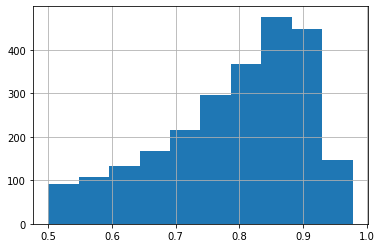

In [7]:
hist = err_analysis[(err_analysis['pred_class'] == 1) & (err_analysis['true_class'] == 1)]['pred_prob'].hist()

In [8]:
err_analysis[(err_analysis['pred_class'] == 0) & (err_analysis['true_class'] == 0)]['pred_prob'].describe(percentiles=perc)

count    2259.000000
mean        0.175663
std         0.131404
min         0.010657
10%         0.041793
20%         0.058662
30.0%       0.079700
40%         0.101148
50%         0.130346
60%         0.171940
70%         0.224206
80%         0.298444
90%         0.390376
max         0.499473
Name: pred_prob, dtype: float64

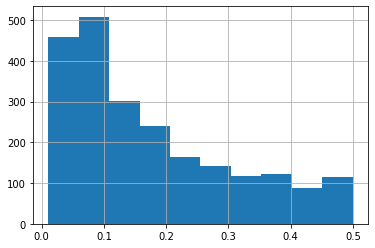

In [9]:
hist = err_analysis[(err_analysis['pred_class'] == 0) & (err_analysis['true_class'] == 0)]['pred_prob'].hist()

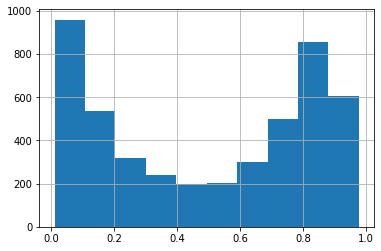

In [10]:
# When predictions are correct, look at how strong the predictions were:
hist = err_analysis[(err_analysis['pred_class'] == 0) & (err_analysis['true_class'] == 0) | (err_analysis['pred_class'] == 1) & (err_analysis['true_class'] == 1)]['pred_prob'].hist()

In [11]:
# Find distances from decision boundary for all
err_analysis['abs_dist'] = abs(err_analysis['pred_prob'] - 0.5)

In [12]:
err_analysis.head()

,Unnamed: 0,pred_prob,pred_class,true_class,abs_dist
0,419,0.977485,1,1.0,0.477485
1,3748,0.976698,1,1.0,0.476698
2,2965,0.976025,1,1.0,0.476025
3,3793,0.971027,1,1.0,0.471027
4,4930,0.970027,1,1.0,0.470027


In [13]:
# When predictions are wrong what is the distribution of predicted values?
err_analysis[err_analysis['pred_class'] != err_analysis['true_class']]['abs_dist'].describe(percentiles=perc)

count    1420.000000
mean        0.203283
std         0.125937
min         0.000243
10%         0.036134
20%         0.076802
30.0%       0.116405
40%         0.153888
50%         0.195700
60%         0.239831
70%         0.282492
80%         0.330658
90%         0.379201
max         0.475078
Name: abs_dist, dtype: float64

In [14]:
# When predictions are correct what is the distribution of predicted values?
err_analysis[err_analysis['pred_class'] == err_analysis['true_class']]['abs_dist'].describe(percentiles=perc)

count    4712.000000
mean        0.306372
std         0.123511
min         0.000195
10%         0.112789
20%         0.192926
30.0%       0.253829
40%         0.299768
50%         0.336667
60%         0.367345
70%         0.394596
80%         0.417928
90%         0.445377
max         0.489343
Name: abs_dist, dtype: float64

In [17]:
def round_down(x, a):
    return math.floor(x / a) * a


def calc_acc(frame, threshold):
    print("Initial Correct Helpful: {}".format(frame[(frame['pred_class'] == 1) & (frame['true_class'] == 1)].shape[0]))
    print("Initial Correct Unhelpful: {}".format(frame[(frame['pred_class'] == 0) & (frame['true_class'] == 0)].shape[0]))
    print("Initial Incorrect Helpful: {}".format(frame[(frame['pred_class'] == 1) & (frame['true_class'] == 0)].shape[0]))
    print("Initial Incorrect Unhelpful: {}".format(frame[(frame['pred_class'] == 0) & (frame['true_class'] == 1)].shape[0]))
    
    if threshold > max(frame['abs_dist']):
        print('{} is a larger threshold than max allowed for this data set'.format(threshold))
        print('Running estimate using max allowed threshold: {}'.format(round_down(max(frame['abs_dist']), 0.1)))
        threshold = round_down(max(frame['abs_dist']), 0.1)
    
    filtered = frame[(frame['abs_dist'] > threshold)]
    
    print()
    print('Reduced from {} examples to {}'.format(frame.shape[0], filtered.shape[0]))
    print()
    
    print("Filtered Correct Helpful: {}".format(filtered[(filtered['pred_class'] == 1) & (filtered['true_class'] == 1)].shape[0]))
    print("Filtered Correct Unhelpful: {}".format(filtered[(filtered['pred_class'] == 0) & (filtered['true_class'] == 0)].shape[0]))
    print("Filtered Incorrect Helpful: {}".format(filtered[(filtered['pred_class'] == 1) & (filtered['true_class'] == 0)].shape[0]))
    print("Filtered Incorrect Unhelpful: {}".format(filtered[(filtered['pred_class'] == 0) & (filtered['true_class'] == 1)].shape[0]))
          
          
    return accuracy_score(filtered['true_class'], filtered['pred_class'])

In [20]:
# How many samples do we sacrifice when we use different threshold values?
calc_acc(err_analysis, 0.1)

Initial Correct Helpful: 2453
Initial Correct Unhelpful: 2259
Initial Incorrect Helpful: 807
Initial Incorrect Unhelpful: 613

Reduced from 6132 examples to 5348

Filtered Correct Helpful: 2247
Filtered Correct Unhelpful: 2051
Filtered Incorrect Helpful: 613
Filtered Incorrect Unhelpful: 437


0.8036649214659686

In [21]:
# sort the dataframe to more easily see the 'strength' of predictions
err_analysis = err_analysis.sort_values(by='pred_prob', ascending=False)
err_analysis

,Unnamed: 0,pred_prob,pred_class,true_class,abs_dist
0,419,0.977485,1,1.0,0.477485
1,3748,0.976698,1,1.0,0.476698
2,2965,0.976025,1,1.0,0.476025
3,3793,0.971027,1,1.0,0.471027
4,4930,0.970027,1,1.0,0.470027
5,5175,0.966906,1,1.0,0.466906
6,4571,0.966837,1,1.0,0.466837
7,1828,0.966607,1,1.0,0.466607
8,6113,0.966428,1,1.0,0.466428
9,1974,0.964291,1,1.0,0.464291


In [22]:
# Look at the predicted probabilities of examples incorrectly assigned to the "helpful" class
err_analysis[err_analysis['pred_class'] != err_analysis['true_class']][:20]

,Unnamed: 0,pred_prob,pred_class,true_class,abs_dist
10,3805,0.963396,1,0.0,0.463396
31,1120,0.955648,1,0.0,0.455648
43,4769,0.952187,1,0.0,0.452187
46,958,0.951315,1,0.0,0.451315
52,3338,0.950091,1,0.0,0.450091
65,1993,0.947648,1,0.0,0.447648
72,3076,0.944904,1,0.0,0.444904
76,1093,0.944029,1,0.0,0.444029
83,916,0.942624,1,0.0,0.442624
110,2012,0.937523,1,0.0,0.437523


In [24]:
#verify misclassified reviews match in the complete labeled test set (non-grouped)
orig_test = pd.read_csv('w266_proj/data/labeled_test_set_clust_FINAL.csv')

In [27]:
# Load grouped test set
test = pd.read_csv('w266_proj/data/test_clust_FINAL.csv')

In [25]:
orig_test.dropna(subset=['reviewText'],inplace=True)

In [28]:
# 1120 is a very confident 'helpful' class prediction that is incorrectly classified, why?
print(test.loc[1120]['prepReviewText'])
print()
print('Predicted: {}'.format(err_analysis.loc[1120]['pred_class']))
print('Actual: {}'.format(test.loc[1120]['group_z_class']))

WORST If You thought Fifty Shades of Grey was the Epitome of Skillful, Erotic Writing, then you will think this book is 5 glowing golden stars and the best thing since Fifty.For me....not so much...I was so confused reading this book and wonder if E.L. James is suing for plagiarism, I mean seriously.. Is this FanFic or just CopyCat. You know how you read a good book and then think "Hmm I wish the character would have done this instead of that", I believe that this author read Fifty, loved it (cue teeny bopper screaming) then thought they could do better by changing it up.Nothing makes sense, not really any descriptive details, Mr. Honor was kinda hot and sexy, I think the tattoos were very bad boy and sexy but that was about the only positive thing I could say.Bad editing, bad writing, She bites her lip..ALOT, and of course he thinks its Sooo sexy. He has 'long fingers', what's with long fingers, is that like big feet, big ears? He Smirks...Alot but he also says things Sadistically or 

In [29]:
# verify review in orig_test set
orig_test[orig_test['reviewText'].str.contains("If You thought Fifty Shades of Grey was the Epitome of Skillful")]

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR,most_helpful,min_max,mean_sd,group_z,group_z_class
309561,147500544X,1,If You thought Fifty Shades of Grey was the Ep...,2012-11-02,A2VS49ZC6M50Q2,Amazon Customer,Ummm Didn't I already buy this??? Oh Yeah!!! I...,1351814400,0,628,0.0,152.0,0.790892,0.740758,0,"(0.0, 5.861313868613139)","(0.7839600862261263, 0.8021508357400886)",-0.977323,0.0


In [30]:
# verify review in grouped test set
test[test['prepReviewText'].str.contains("If You thought Fifty Shades of Grey was the Epitome of Skillful")]

,Unnamed: 0,prepReviewText,group_z_class
1120,2753,WORST If You thought Fifty Shades of Grey was ...,0.0


In [31]:
print(test.loc[3805]['prepReviewText'])
print()
print('Predicted: {}'.format(err_analysis.loc[3805]['pred_class']))
print('Actual: {}'.format(test.loc[3805]['group_z_class']))

WORST I grant the authors/editor points for novelty and stretching the evangelical envelope. But the envelope tears when attempting to build a case for the validity of an 'open god', who is more than just open to our input and prayers, for example, but who is unable to know as definite in advance just what that input will be. In attempting to arrive at a viable alternative to the Classical Evangelical view (God has Exhaustive Divine/DefiniteForeknowledge of all free-agent decisions), openness comes up with 'Extensive Temporal Forecasting', something clearly no longer considered OMNISCIENCE in anyone's theological dictionary.This book simply fails to cogently or Biblically support a compelling reason to jettison the position held by Old Testament Judaism, New Testament apostolic authors, Christ Himself, Early Church Fathers (Athanasius,Augustine,etc.), Reformers (Luther,Calvin,Melanchthon,Oecolampadius,Bucer, Zwingli,Knox) and latertheologians (Arminius,Wesley,Edwards,Spurgeon,Walther,P

In [32]:
# verify review in orig_test set
orig_test[orig_test['reviewText'].str.contains("I grant the author")]

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR,most_helpful,min_max,mean_sd,group_z,group_z_class
306298,0830818529,1,I grant the authors/editor points for novelty ...,2001-10-16,AGBHLVDAQNYIN,Brentley,WARMED OVER SYNTHESIS OF PROCESSISM/CLASSICALISM,1003190400,0,4663,0.0,11.0,1.019642,2.156331,0,"(0.0, 4.212935323383085)","(1.3883968834342957, 1.1782429714210987)",-1.178362,0.0


In [33]:
# verify review in grouped test set
test[test['prepReviewText'].str.contains("I grant the author")]

,Unnamed: 0,prepReviewText,group_z_class
3805,1948,WORST I grant the authors/editor points for no...,0.0


In [34]:
print(test.iloc[4769]['prepReviewText'])
print()
print('Predicted: {}'.format(err_analysis.loc[4769]['pred_class']))
print('Actual: {}'.format(test.loc[4769]['group_z_class']))

BEST "A popular hangover cure called for two ounces of opium, one of saffron, a dash of cloves and cinnamon, and a pint of wine, though perhaps in an emergency you could skip the cinnamon." - Barbara Holland in THE JOY OF DRINKINGIn this relatively short (148 pages), small format hardcover, Barbara Holland explores mankind's long-standing love-hate relationship with booze. In order to establish the universal appeal of alcoholic beverages, she reminds the reader that such have an honored past in such far flung and widely disparate civilizations as ancient China, Aztecan Mexico, Mohammad-era Arabia, nomadic Mongolia, Tahiti, Central Africa, Nepal, the Amazonian jungle, and ancient Babylon, Greece, Rome and Egypt. She fails to mention the Eskimos.Entering the more or less modern era, Holland next focuses on England with its beer, ale, gin, tankards, and taverns. Then, she skips across The Pond to England's political and sociological offspring, the Thirteen Colonies, eventually to become t

In [35]:
# verify review in orig_test set
orig_test[orig_test['reviewText'].str.contains("A popular hangover cure called for two ounces of opium")]

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR,most_helpful,min_max,mean_sd,group_z,group_z_class
135511,1596913371,5,"""A popular hangover cure called for two ounces...",2008-01-11,A2DSXA1E02C86D,Joseph Haschka,Gettin' all likkered-up,1200009600,0,2385,0.0,6.0,1.802515,0.484079,0,"(0.0, 4.700757575757576)","(1.0905801803507265, 1.604757771404871)",-0.679592,0.0


In [36]:
# verify review in grouped test set
test[test['prepReviewText'].str.contains("A popular hangover cure called for two ounces of opium")]

,Unnamed: 0,prepReviewText,group_z_class
4769,4232,"BEST ""A popular hangover cure called for two o...",0.0


In [37]:
# What about in the opposite direction? What reviews have strong "unhelpful" predictions that were actually "helpful" ?
err_analysis[err_analysis['pred_class'] != err_analysis['true_class']][-20:]

,Unnamed: 0,pred_prob,pred_class,true_class,abs_dist
5775,5439,0.050421,0,1.0,0.449579
5791,4928,0.048824,0,1.0,0.451176
5801,32,0.048516,0,1.0,0.451484
5805,1637,0.048282,0,1.0,0.451718
5817,45,0.047332,0,1.0,0.452668
5861,5883,0.044508,0,1.0,0.455492
5867,4179,0.044020,0,1.0,0.455980
5893,6084,0.041785,0,1.0,0.458215
5915,734,0.039586,0,1.0,0.460414
5929,1784,0.038472,0,1.0,0.461528


In [38]:
# 5439 is a very confident 'unhelpful' class prediction that is incorrectly classified, why?
print(test.loc[5439]['prepReviewText'])
print()
print('Predicted: {}'.format(err_analysis.loc[5439]['pred_class']))
print('Actual: {}'.format(test.loc[5439]['group_z_class']))

WORST Started out ok, but it got a bit confusing. I realize it is a short story but there was too much going on.

Predicted: 0.0
Actual: 1.0


In [39]:
# verify review in orig_test set
orig_test[orig_test['reviewText'].str.contains("Started out ok, but it got a bit confusing")]

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR,most_helpful,min_max,mean_sd,group_z,group_z_class
309843,1481032585,1,"Started out ok, but it got a bit confusing. I ...",2012-12-11,A1R72KSDVPMNXT,"Beth Hand ""mzbetherz""",Jumps around too much,1355184000,8,589,4.957555,49.0,2.86399,1.220736,1,"(0.0, 14.697986577181208)","(1.481555316154205, 2.565526983941557)",1.354887,1.0


In [40]:
# verify review in grouped test set
test[test['prepReviewText'].str.contains("Started out ok, but it got a bit confusing")]

,Unnamed: 0,prepReviewText,group_z_class
5439,470,"WORST Started out ok, but it got a bit confusi...",1.0


In [41]:
# 4928 is a very confident 'unhelpful' class prediction that is incorrectly classified, why?
print(test.loc[4928]['prepReviewText'])
print()
print('Predicted: {}'.format(err_analysis.loc[4928]['pred_class']))
print('Actual: {}'.format(test.loc[4928]['group_z_class']))

BEST A must review to understand the public opinions pre-war with the British. Attitudes are amazingly different that common conceptions. Great read. Well-writte. A must for those interested in American History

Predicted: 0.0
Actual: 1.0


In [42]:
# verify review in orig_test set
orig_test[orig_test['reviewText'].str.contains("A must review to understand the public opinions pre-war with the British")]

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR,most_helpful,min_max,mean_sd,group_z,group_z_class
152009,B007EWAP3E,5,A must review to understand the public opinion...,2012-05-07,ADV5Q5NF0J7YQ,"The Little Man ""Intellectual Giant""",This was an eye opener,1336348800,10,807,4.522924,8.0,0.934801,1.162399,1,"(0.0, 4.522924411400248)","(1.2131563469733855, 1.3337954060433233)",2.481466,1.0


In [43]:
# verify review in grouped test set
test[test['prepReviewText'].str.contains("A must review to understand the public opinions pre-war with the British")]

,Unnamed: 0,prepReviewText,group_z_class
4928,6010,BEST A must review to understand the public op...,1.0


In [44]:
# 32 is a very confident 'unhelpful' class prediction that is incorrectly classified, why?
print(test.loc[32]['prepReviewText'])
print()
print('Predicted: {}'.format(err_analysis.loc[32]['pred_class']))
print('Actual: {}'.format(test.loc[32]['group_z_class']))

BEST I love all of the books in this series. I only wish they were longer it seems I start to read and a few minutes later I am done.

Predicted: 1.0
Actual: 1.0


In [45]:
# verify review in orig_test set
orig_test[orig_test['reviewText'].str.contains("I love all of the books in this series. I only wish they were longer")]

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR,most_helpful,min_max,mean_sd,group_z,group_z_class
145861,1936730731,5,I love all of the books in this series. I only...,2013-02-05,A190ES06M8Y1ZF,McCormick,Love the series,1360022400,3,533,2.054409,15.0,0.344942,0.862889,1,"(0.6260720411663808, 2.054409005628518)","(0.8910947700157436, 0.4173941653493726)",2.787088,1.0


In [46]:
# verify review in grouped test set
test[test['prepReviewText'].str.contains("I love all of the books in this series. I only wish they were longer")]

,Unnamed: 0,prepReviewText,group_z_class
32,5814,BEST I love all of the books in this series. I...,1.0


## Interpretation


In [48]:
train = pd.read_csv('w266_proj/data/train_clust_FINAL.csv')
train['rev_length'] = train['prepReviewText'].apply(lambda x: len(x.split()))
train.groupby('group_z_class')['rev_length'].describe()

,count,mean,std,min,25%,50%,75%,max
group_z_class,,,,,,,,
0.0,26066.0,93.680810,140.195543,4.0,29.0,50.0,103.0,5398.0
1.0,26066.0,289.184608,297.304502,7.0,108.0,206.0,368.0,5594.0
